C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


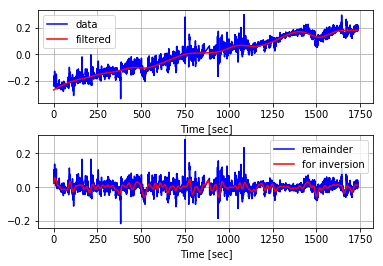

C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


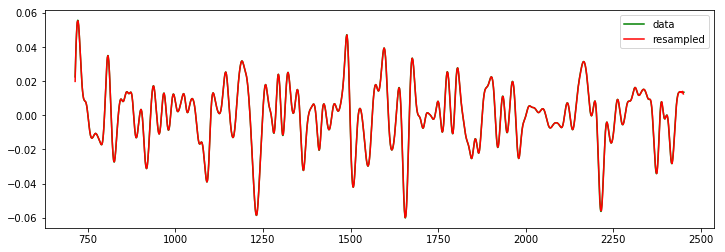

In [158]:
from petrel_well_file_readers import *
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import lasio
from flex_log import FlexXY,FlexLog
from seis_ampl_spectrum import *
folder=r'D:\SoftwareWebApps\Python\geophysics\inversion&spect_decomp\d11_data\\'
# folder=r"D:\Ameyem\python\inversion&spectraldecomp\d11_data\\"
las_file=folder+'nec25_a1.las'
las=lasio.read(las_file)

# well_tops_file=folder+'d11_welltops_payzones_220519_sai.dat'
# wt=read_welltops(well_tops_file)
# wt=wt.sort_values(['MD'])

chkt_file=folder+"nec25_a1_chkt.dat"
chkt=read_chkt(chkt_file)
X=chkt['MD'].values
X.shape=len(X),1
y=chkt['TWT picked'].values
md2twt = LinearRegression().fit(X, y)

las=lasio.read(las_file)
flexlog = FlexLog(np.array([[0,0]]))
x,y=las['DEPT'],las['AI']
x,y=flexlog.get_nonanXYs(x,y)
# plt.plot(x,y)

#seismic trace
from petrel_well_file_readers import *
file=folder+'nec25_a1_NORTH_SEIS.dat'
seis_signal=read_tworowfile(file,nheadrows=2)
seisflexlog = FlexLog(np.column_stack((seis_signal['TWT'],seis_signal['Trace'])))


# 1/(dt/1000)
# fc = 30  # Cut-off frequency of the filter
# w = fc / (fs / 2) # Normalize the frequency
def norm(x):
    return (x - np.mean(x)) / np.std(x)
from bruges.filters import ricker as ricker_
FS = 1/0.002
def ricky(length, width):
    return ricker_(0.256, 1/FS, width)

wavelet=ricky(400,20)
dt=2
freq, amp=ampspec(wavelet.T,dt)
f_peak = freq[np.argmax(amp)]
# plot_ampspec(freq,amp,f_peak,name=None)
# import segyio
# from seis_readers import *
# file=folder+'NEC-OSN-97_2_North_crop.sgy'
# sdata, nsamples, sr, stwt, ntraces, header, inlines, crosslines=read_segy(file)

from scipy import signal

md=x
md.shape=len(md),1
twt=md2twt.predict(md)
t=-twt+twt[0]
# plt.plot(twt,y)
# plt.gca().invert_xaxis()
# plt.figure()
# plt.plot(x,y)

dt=np.mean(np.diff(t))
# y.shape=len(y),1
# freq, amp=ampspec(y.T,dt)
# f_peak = freq[np.argmax(amp)]
# plot_ampspec(freq,amp,f_peak,name=None)


nclip=0
# t=-twt[nclip:]+twt[nclip:][0]

# a=np.array([4587.4941406 , 4722.09412164, 4796.70790784])
# a[::-1]
n=len(t)
dt=np.mean(np.diff(t))
T=t[-1]/1000
fs=n/T

t=-twt[nclip:]+twt[nclip:][0]
# data=norm(y[nclip:])
maxai=max(y[nclip:])
data=y[nclip:]/maxai
meanai=np.mean(data)
data=data-meanai

# data=data/max(data)




fc = 5  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
order=3
b, a = signal.butter(order, w, 'low')
output = signal.filtfilt(b, a, data)
plt.subplot(2, 1, 1)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, output,'r-', label='filtered')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
########################################################
data=data-output #removing low frequency component
########################################################
fc = 40  # Cut-off frequency of the filter 70 gave 36%, 12.6ms bs
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(order, w, 'low')
ai_for_inv = signal.filtfilt(b, a, data)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='remainder')
plt.plot(t, ai_for_inv,'r-', label='for inversion')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

# x.shape,y.shape,xnew.shape
# present_dt=np.mean(np.diff(x))
# dt=4
# ns=nresamples(y,present_dt,dt)
# ns
# # np.linspace(x[0], x[-1], ns, endpoint=False)
# new_tstart=np.ceil(t[0]+(-twt[0]))
# if new_tstart%2!=0:
#     new_tstart+=1
# # new_tstart,-twt[0]
# new_tstart-(-twt[0])

from scipy import signal

new_tstart=np.ceil(t[0]+(-twt[0])) # time need to match with seismic time 
if new_tstart%2!=0:
    new_tstart+=1
    

sample_start=new_tstart-(-twt[0])
###############################################################
x,y=t,ai_for_inv #making removed high frequency signal as main
# x,y=t,data
###############################################################
# x = np.linspace(0, 10, 20, endpoint=False)
# y = np.cos(-x**2/6.0)
def nresamples(x,present_dt,req_dt):
    return int(len(x) / (req_dt * present_dt))
def myresample(x,y,sample_start=0,dt=4):
    xnew=np.arange(sample_start,x[-1]+0.001,dt)
    res_y = signal.resample(y, len(xnew))
    return xnew,res_y

import matplotlib.pyplot as plt
tnew,ai_res=myresample(x,y,dt=2)
tnew=tnew+new_tstart
x=x+new_tstart
plt.figure(figsize=(12,4))
# plt.plot(t, data, 'y-')
plt.plot(x, y, 'g-', tnew, ai_res, 'r-')
# plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()


# dt=2
# freq, amp=ampspec(ai_res.T,dt)
# f_peak = freq[np.argmax(amp)]
# plot_ampspec(freq,amp,f_peak,name=None)


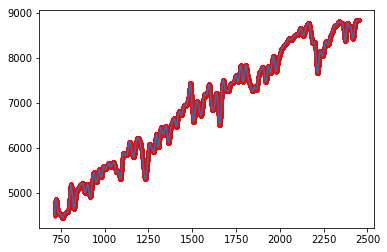

In [171]:
# plt.plot((ai_res[1:]+ai_res[:-1]))
# plt.plot((ai_res[1:]+ai_res[:-1]))
# 1/np.mean(abs(ai_res[1:]+ai_res[:-1]))
lai=ai_for_inv+output
rec_ai=(lai+meanai)*maxai
# t-twt[0],tnew
plt.plot(t-twt[0],rec_ai,'.r')
ai_flex=FlexLog(np.column_stack((t-twt[0],rec_ai)))
ai_res=ai_flex.resampleXYs(tnew)
plt.plot(ai_res[:,0],ai_res[:,1])

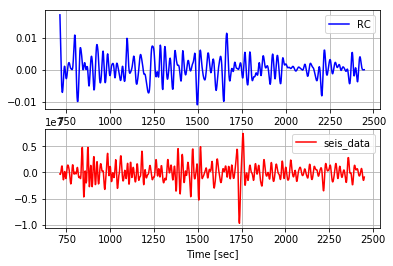

In [176]:
tnew
rc=(ai_res[1:,1]-ai_res[:-1,1])/(ai_res[1:,1]+ai_res[:-1,1])
seis_data=seisflexlog.resampleXYs(tnew)
plt.subplot(2, 1, 1)
plt.plot(tnew[:-1], rc, 'b-', label='RC')
# plt.plot(ai_res[:,0],ai_res[:,1])
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tnew, seis_data[:,1], 'r-', label='seis_data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

np.save('d11_t_ai_rc_seis.npy',(tnew[:-1],ai_res[:-1,1],rc,seis_data[:-1,1]))

In [2]:
# def norm(x):
#     return (x - np.mean(x)) / np.std(x)
# seis_resamp=seisflexlog.resampleXYs(tseis)
# plt.plot(norm(seis_resamp[:,1]))
# # print(np.mean(seis_resamp[:,1]),np.std(seis_resamp[:,1]))

In [24]:

n_prev=100
n_after=100
n_out_feat=1
dt=2 #ms
mydt=np.mean(np.diff(tnew))
tseis=np.append(np.arange(tnew[0]-n_prev*mydt-20,tnew[0],mydt),tnew)
tseis=np.append(tseis,np.arange(tnew[-1]+mydt,tnew[-1]+n_after+n_out_feat+20,mydt))
seis_resamp=seisflexlog.resampleXYs(tseis)
# seis_resamp[:,1]=norm(seis_resamp[:,1])
seis_resamp[:,1]=seis_resamp[:,1]/np.max(seis_resamp[:,1])
# np.unique(np.diff(tseis))
# ai_res=ai_res
X=Y=[]
feature_len=n_prev+n_out_feat+n_after
# X=np.zeros(feature_len)
out_feature_len=n_out_feat
# Y=np.zeros(out_feature_len)
# Y.shape=len(Y),1
for i,t in enumerate(tnew[:-n_out_feat]):
#     print(seis_resamp[tid-n_prev:tid+n_out_feat+n_after,1].size,end=' ')
    tid=np.where(tseis==t)[0][0]
    xfeatures=seis_resamp[tid-n_prev:tid+n_out_feat+n_after,1]
    if xfeatures.shape[0]==feature_len:
#     print(seis_resamp[tid-n_prev:tid+n_out_feat+n_after,1].shape,end=' ')
        X=np.append(X,xfeatures,axis=0)
        Y=np.append(Y,ai_res[i:i+n_out_feat],axis=0)
print(X.shape,Y.shape)
X.shape=int(X.shape[0]/feature_len),feature_len
Y.shape=int(Y.shape[0]/out_feature_len),out_feature_len
print(X.shape,Y.shape)

(166629,) (829,)
(829, 201) (829, 1)


In [25]:
feature_len

201

(array([ 14.,  13.,  38.,  91., 185., 281., 165.,  60.,  15.,   7.]),
 array([-0.45633229, -0.36843556, -0.28053882, -0.19264209, -0.10474536,
        -0.01684863,  0.07104811,  0.15894484,  0.24684157,  0.33473831,
         0.42263504]),
 <a list of 10 Patch objects>)

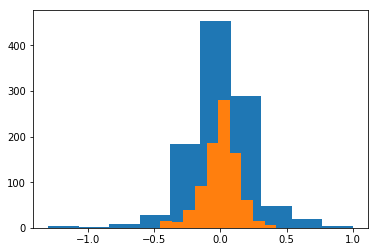

In [26]:
# [print('{:3.2f}'.format(s),end=' ') for s in seis_resamp[:,1]]
# np.array(X).shape





plt.hist(seis_resamp[:,1])
plt.hist(ai_res)

In [27]:
from sklearn import model_selection
validation_size = 0.3
seed = 7
tid=int(validation_size*X.shape[0])
X_train, X_validation, Y_train, Y_validation =X[:tid,:],X[tid:,:],Y[:tid,:],Y[tid:,:]
# X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
X_train, X_validation, Y_train, Y_validation=np.float32(X_train), np.float32(X_validation), \
                                        np.float32(Y_train), np.float32(Y_validation)

In [28]:
# !pip install keras

In [29]:
np.save('seis_inversion.npy',(X_train, X_validation, Y_train, Y_validation))

In [71]:
# # X_train[200,:]
# display_step = 2000
# bdisplay_step = 100
# minbatch_size=100
# training_epochs = 1000

# rand_index = np.random.choice(n_samples,minbatch_size)
# # rand_index.shape

In [132]:
import tensorflow as tf
import keras
from keras import layers
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[X_train.shape[1]]),  
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(out_feature_len)
    ]) #layers.Dense(32, activation=tf.nn.relu),

    optimizer = keras.optimizers.RMSprop(0.0005)
#     optimizer=tf.train.AdamOptimizer(0.0005)
#     optimizer =keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
#     optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                12928     
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
Total params: 15,041
Trainable params: 15,041
Non-trainable params: 0
_________________________________________________________________


In [133]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    i=0
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            self.i+=1
            print(self.i,'')
        print('.', end='')

EPOCHS = 1500

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS,  verbose=0,validation_split = 0.1,
  callbacks=[PrintDot()]) #validation_split = 0.2,

1 
....................................................................................................2 
....................................................................................................3 
....................................................................................................4 
....................................................................................................5 
....................................................................................................6 
....................................................................................................7 
....................................................................................................8 
....................................................................................................9 
....................................................................................................10 
.....................................................................

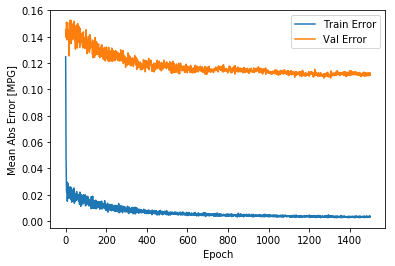

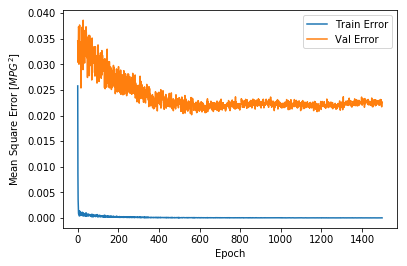

In [130]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)

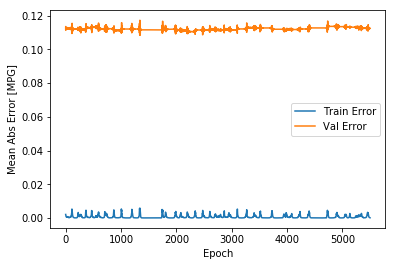

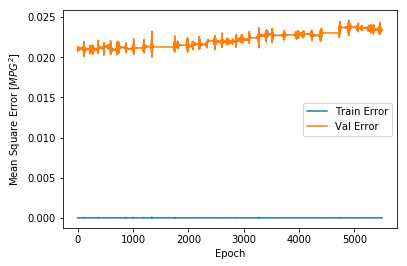

In [100]:
# Y_validation.shape[1]
# # X_train[0]
plot_history(history)

0.14451340839365995


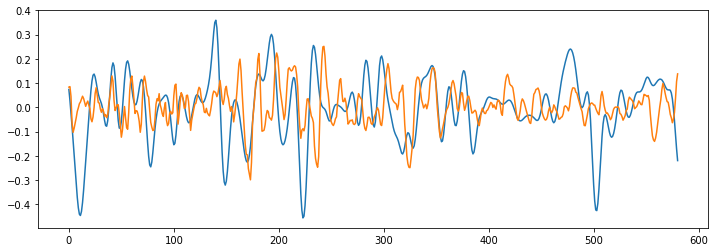

In [131]:
def merge_y(Y_validation):
    
    yvlen=Y_validation.shape[1]
    if yvlen==1:
        yv_reconst=Y_validation.copy()
        yv_reconst.shape=Y_validation.shape[0]
        return yv_reconst
    yv_reconst=Y_validation[0]
    for yv in Y_validation[1:]:
        yv_reconst=np.append(yv_reconst[:-yvlen+1],np.mean((yv_reconst[-yvlen+1:],yv[:-1]),axis=0))
        yv_reconst=np.append(yv_reconst,yv[-1])
    return yv_reconst
def corr_coef(seq_predictions, seq_labels): 
# 	correctly_predicted = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
# 	accu = (100.0 * correctly_predicted) / predictions.shape[0] 
	return np.corrcoef( merge_y(seq_labels),merge_y(seq_predictions))[0,1]
Y_validation_pred = model.predict(X_validation)
plt.figure(figsize=(12,4))
plt.plot(merge_y(Y_validation))  
plt.plot(merge_y(Y_validation_pred))  

print(np.corrcoef( merge_y(Y_validation),merge_y(Y_validation_pred))[0,1])

C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


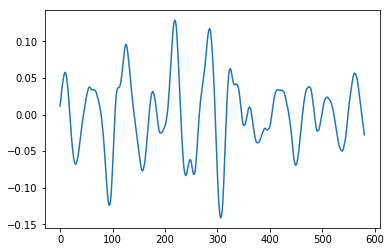

In [234]:
from scipy import signal
rc_real,rc_pred=merge_y(Y_validation),merge_y(Y_validation_pred)
corr=signal.correlate(rc_real,rc_pred , mode='same')
plt.plot(corr)

In [235]:
# np.argmax(corr)
dtt=0.002
tdiff=dtt*(np.argmax(corr)-len(corr)/2)
print(tdiff,np.corrcoef( rc_real,rc_pred))

-0.14300000000000002 [[1.         0.19601014]
 [0.19601014 1.        ]]


In [39]:
dt

2

In [118]:
from __future__ import print_function
import numpy as np
import tensorflow as tf

from tensorflow.python.ops import resources
from tensorflow.contrib.tensor_forest.python import tensor_forest

X_train, X_validation, Y_train, Y_validation=np.load('seis_inversion.npy')
X_train, X_validation, Y_train, Y_validation=np.float32(X_train), np.float32(X_validation), \
                                        np.float32(Y_train), np.float32(Y_validation)
n_samples,num_features=X_train.shape
num_classes=Y_train.shape[1]
# batch_size=n_samples
# batch_size,num_features,num_classes

# number of features 
num_features = num_features
# number of target labels 
num_labels = num_classes
# learning rate (alpha) 
learning_rate = 0.01
# batch size 
batch_size = 128
# number of epochs 
num_steps = 50001

# input data 
train_dataset = X_train
train_labels = Y_train
# test_dataset = mnist.test.images 
# test_labels = mnist.test.labels 
valid_dataset = X_validation
valid_labels = Y_validation

# initialize a tensorflow graph 
graph = tf.Graph() 

with graph.as_default(): 
	""" 
	defining all the nodes 
	"""

	# Inputs 
	tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, num_features)) 
	tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) 
	tf_valid_dataset = tf.constant(valid_dataset) 
# 	tf_test_dataset = tf.constant(test_dataset) 

	# Variables. 
	weights = tf.Variable(tf.truncated_normal([num_features, num_labels])) 
	biases = tf.Variable(tf.zeros([num_labels])) 
    
#     optcost = tf.reduce_sum(tf.pow(pred1-Y, 2))/(2*n_samples)
# # Gradient descent
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(optcost)

	# Training computation. 
	logits = tf.matmul(tf_train_dataset, weights) + biases 
	loss = tf.reduce_mean(tf.pow(logits-tf_train_labels,2)) 

	# Optimizer. 
	optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) 

	# Predictions for the training, validation, and test data. 
	train_prediction = logits
	valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
# 	test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases) 


In [119]:
# utility function to calculate accuracy 



with tf.Session(graph=graph) as session: 
    # initialize weights and biases 
    tf.global_variables_initializer().run() 
    print("Initialized") 

    for step in range(num_steps): 
        # pick a randomized offset 
        offset = np.random.randint(0, train_labels.shape[0] - batch_size - 1) 

        # Generate a minibatch. 
        batch_data = train_dataset[offset:(offset + batch_size), :] 
        batch_labels = train_labels[offset:(offset + batch_size), :] 

        # Prepare the feed dict 
        feed_dict = {tf_train_dataset : batch_data, 
                    tf_train_labels : batch_labels} 

        # run one step of computation 
        _, l, predictions = session.run([optimizer, loss, train_prediction], 
                                        feed_dict=feed_dict) 

        if (step % 500 == 0): 
            print("Minibatch loss at step {:5d}: {:.4f}".format(step, l),end=' | ') 
        # 			print("Minibatch accuracy: {:.1f}%".format( 
        # 				accuracy(predictions, batch_labels))) 
            print("Coorelation Coeff: {:.1f}%".format( 100*corr_coef(valid_prediction.eval(), valid_labels))) 
    fW=weights.eval()
    fb=biases.eval()
    Y_validation_pred= valid_prediction.eval()
# 	print("\nTest accuracy: {:.1f}%".format( 
# 		accuracy(test_prediction.eval(), test_labels))) 


Initialized
Minibatch loss at step     0: 3.3358 | Coorelation Coeff: 6.7%
Minibatch loss at step   500: 0.9726 | Coorelation Coeff: 6.3%
Minibatch loss at step  1000: 0.4830 | Coorelation Coeff: 5.6%
Minibatch loss at step  1500: 0.3020 | Coorelation Coeff: 4.9%
Minibatch loss at step  2000: 0.2055 | Coorelation Coeff: 4.4%
Minibatch loss at step  2500: 0.1391 | Coorelation Coeff: 3.8%
Minibatch loss at step  3000: 0.1133 | Coorelation Coeff: 3.3%
Minibatch loss at step  3500: 0.0885 | Coorelation Coeff: 2.8%
Minibatch loss at step  4000: 0.0748 | Coorelation Coeff: 2.2%
Minibatch loss at step  4500: 0.0684 | Coorelation Coeff: 1.6%
Minibatch loss at step  5000: 0.0507 | Coorelation Coeff: 1.1%
Minibatch loss at step  5500: 0.0439 | Coorelation Coeff: 0.6%
Minibatch loss at step  6000: 0.0493 | Coorelation Coeff: 0.1%
Minibatch loss at step  6500: 0.0288 | Coorelation Coeff: -0.4%
Minibatch loss at step  7000: 0.0264 | Coorelation Coeff: -0.8%
Minibatch loss at step  7500: 0.0379 | Co

[[ 1.          0.96500513  0.91239177 ... -0.60907103 -0.56346679
  -0.46950709]
 [ 0.96500513  1.          0.98489302 ... -0.65957962 -0.60611019
  -0.51759225]
 [ 0.91239177  0.98489302  1.         ... -0.67444254 -0.61089562
  -0.51915586]
 ...
 [-0.60907103 -0.65957962 -0.67444254 ...  1.          0.9713937
   0.93326564]
 [-0.56346679 -0.60611019 -0.61089562 ...  0.9713937   1.
   0.98429559]
 [-0.46950709 -0.51759225 -0.51915586 ...  0.93326564  0.98429559
   1.        ]]


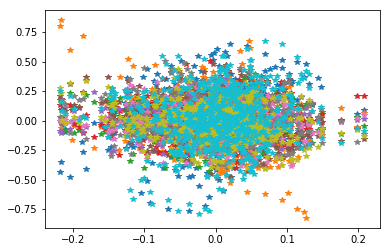

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(Y_validation[:],Y_validation_pred[:],'*')
print(np.corrcoef( Y_validation[:],Y_validation_pred[:]))

In [67]:
# Y_validation.shape=Y_validation.shape[0]*Y_validation.shape[1]
# Y_validation_pred.shape=Y_validation_pred.shape[0]*Y_validation_pred.shape[1]
# print(np.corrcoef( Y_validation,Y_validation_pred))
Y_validation.shape=int(Y_validation.shape[0]/num_labels),num_labels
Y_validation_pred.shape=int(Y_validation_pred.shape[0]/num_labels),num_labels
Y_validation

array([[-0.18677297, -0.21065076, -0.21656205, ..., -0.08339304,
        -0.07003701, -0.05741949],
       [-0.21065076, -0.21656205, -0.20168479, ..., -0.07003701,
        -0.05741949, -0.03817662],
       [-0.21656205, -0.20168479, -0.17101653, ..., -0.05741949,
        -0.03817662, -0.00880358],
       ...,
       [-0.00562941,  0.01865964,  0.03221003, ...,  0.03867961,
         0.0401761 ,  0.04497821],
       [ 0.01865964,  0.03221003,  0.03809091, ...,  0.0401761 ,
         0.04497821,  0.04464531],
       [ 0.03221003,  0.03809091,  0.03701681, ...,  0.04497821,
         0.04464531,  0.04951688]], dtype=float32)

In [96]:
# u=np.mean(([1,2,3],[1,3,4]),axis=0)
# u[-len(u)+1
print("Validation accuracy: {:.1f}%".format( 100*0.02))

Validation accuracy: 2.0%


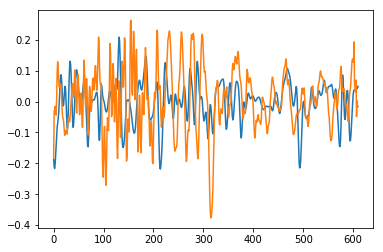

In [87]:


#     print(yv_reconst.shape)
#     break
plt.plot(merge_y(Y_validation))  
plt.plot(merge_y(Y_validation_pred))  

print(np.corrcoef( merge_y(Y_validation),merge_y(Y_validation_pred))[0,1])

C:\Users\Arun\Anaconda3\Lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


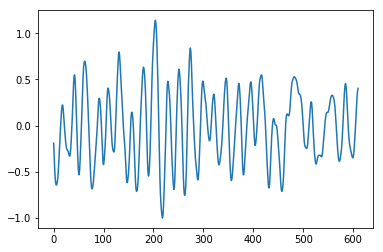

In [92]:
from scipy import signal
plt.plot(signal.correlate( merge_y(Y_validation),merge_y(Y_validation_pred), mode='same'))